In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve
def cross_validate_learning_rate(estimator, x_train, y_train, cv = 5, scoring = 'roc_auc', return_train_score = True):
    results = cross_validate(estimator,
                            x_train,
                            y_train,
                            cv = cv,
                            scoring=scoring,
                            return_train_score = return_train_score ) 
    train_scores = results['train_score']
    test_scores = results['test_score']
    print("train_scores: {}".format(np.mean(train_scores)))
    print("test_scores: {}".format(np.mean(test_scores)))

    lc = learning_curve(estimator, 
                        x_train, 
                        y_train, 
                        cv=cv, 
                        scoring=scoring)
    samples, train, test = lc[0],lc[1],lc[2]
    plt.plot(samples, np.mean(train, axis=1))
    plt.plot(samples, np.mean(test, axis=1))

In [18]:
from sklearn.model_selection import GridSearchCV
def grid_search_param(X, y,nfolds, param_grid, model_sklearn, scoring = 'roc_auc'):
    grid_search = GridSearchCV(model_sklearn, param_grid, cv=nfolds, return_train_score=True, scoring=scoring)
    grid_search.fit(X, y)
    return grid_search

In [19]:
path = '../data'
y_train = pd.read_csv(f'{path}/y_train.csv', index_col = 'key_value')

In [20]:
list_train_probs = []
list_train_probs.append(pd.read_pickle('train_probs_catboost.pkl'))
list_train_probs.append(pd.read_pickle('train_probs_lightgbm.pkl'))
list_train_probs.append(pd.read_pickle('train_probs_lightgbm_cf.pkl'))
# list_train_probs.append(pd.read_pickle('train_probs_lightgbm_cf_v2.pkl'))
# list_train_probs.append(pd.read_pickle('train_probs_rnn.pkl'))
# list_train_probs.append(pd.read_pickle('train_probs_randomforrest.pkl'))
# list_train_probs.append(pd.read_pickle('train_probs_gbc.pkl'))
train = pd.concat(list_train_probs, axis=1)
train.columns = ['probs_catboost','probs_lightgbm','probs_lightgbm_cf']#,'probs_lightgbm_cf_v2','probs_randomforrest','probs_gbc']
train

,probs_catboost,probs_lightgbm,probs_lightgbm_cf
key_value,,,
0,0.113719,0.075889,0.052167
1,0.168120,0.180585,0.157569
2,0.020310,0.028284,0.029362
3,0.009902,0.006474,0.006416
4,0.977649,0.914879,0.934945
...,...,...,...
358482,0.057326,0.052474,0.030986
358483,0.074202,0.058666,0.067142
358484,0.276614,0.340211,0.328420


In [21]:
list_test_probs = []
list_test_probs.append(pd.read_pickle('test_probs_catboost.pkl'))
list_test_probs.append(pd.read_pickle('test_probs_lightgbm.pkl'))
list_test_probs.append(pd.read_pickle('test_probs_lightgbm_cf.pkl'))
# list_test_probs.append(pd.read_pickle('test_probs_lightgbm_cf_v2.pkl'))
# list_test_probs.append(pd.read_pickle('test_probs_rnn.pkl'))
# list_test_probs.append(pd.read_pickle('test_probs_randomforrest.pkl'))
# list_test_probs.append(pd.read_pickle('test_probs_gbc.pkl'))
test = pd.concat(list_test_probs, axis=1)
test.columns = ['probs_catboost','probs_lightgbm','probs_lightgbm_cf']#,'probs_lightgbm_cf_v2','probs_randomforrest','probs_gbc']
test

,probs_catboost,probs_lightgbm,probs_lightgbm_cf
key_value,,,
0,0.003797,0.003765,0.005564
1,0.086857,0.079557,0.126402
2,0.047736,0.028079,0.033458
3,0.511023,0.494312,0.541675
4,0.253204,0.171869,0.198475
...,...,...,...
396661,0.075533,0.082100,0.057302
396662,0.211804,0.189149,0.276789
396663,0.285524,0.238477,0.274746


In [22]:
train.corr()

,probs_catboost,probs_lightgbm,probs_lightgbm_cf
probs_catboost,1.000000,0.974255,0.966506
probs_lightgbm,0.974255,1.000000,0.979399
probs_lightgbm_cf,0.966506,0.979399,1.000000


In [23]:
test.corr()

,probs_catboost,probs_lightgbm,probs_lightgbm_cf
probs_catboost,1.000000,0.989564,0.983691
probs_lightgbm,0.989564,1.000000,0.989030
probs_lightgbm_cf,0.983691,0.989030,1.000000


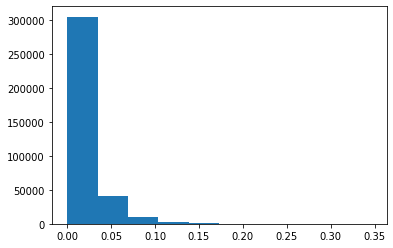

In [24]:
plt.hist(np.std(train.values, axis=1));

### Entrenando el modelo final

In [25]:
from sklearn.linear_model import LogisticRegression
### definir los parametros a tunear
Cs = [0.1, 0.3, 0.8, 0.9, 1.0]
# https://neurtu.readthedocs.io/examples/logistic_regression_scaling.html
solvers = ['lbfgs','saga','newton-cg'] # newton-cg, sag, lbfgs, liblinear, saga
param_grid = {'C': Cs,'solver':solvers}
### encontrando los hiper_parámetros
fitting=grid_search_param(train, y_train.target, 5,param_grid, LogisticRegression(penalty="l2", tol=0.0001, random_state=42), scoring='roc_auc')
### instanciar el estimador
estimator = fitting.best_estimator_
print(estimator)
### aplicar cross_validate y learning_rate 
# cross_validate_learning_rate(estimator, train, y_train, scoring='roc_auc')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)


train_scores: 0.8483484298562001
test_scores: 0.8483317744442684


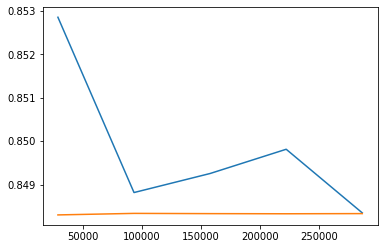

In [26]:
### aplicar cross_validate y learning_rate 
cross_validate_learning_rate(estimator, train, y_train.target, scoring='roc_auc')

In [27]:
estimator.fit(train, y_train.target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
test_stacking = pd.Series(estimator.predict_proba(test)[:,-1], index=test.index, name = 'target')
test_stacking

key_value
0         0.046014
1         0.082324
2         0.055641
3         0.590789
4         0.150503
            ...   
396661    0.070329
396662    0.173205
396663    0.211376
396664    0.058551
396665    0.068611
Name: target, Length: 396666, dtype: float64

In [29]:
test_stacking.to_csv("../results/stacking_3models_CB_LGBM2_0.84833.csv") ### score de 0.84992 en la tabla publica
# test_stacking.to_csv("../results/stacking_2models_CB_LGBM_0.84721.csv") ### score de 0.84882 en la tabla publica